# Detrended WLC corner plots

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz as az
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

## [Dowload data](https://www.dropbox.com/sh/n2mlcmsi9e3g0t6/AAB8n5PKb9MzGq3-BN33Okppa?dl=1) (same dataset used for detrended WLCs)

Unzip this into a folder named `data` in the same level as this notebook

## Finish set-up

In [3]:
# Link dirs
! ln -srf data/detrended_wlcs data/detrended_wlcs_corners

## Load

In [3]:
# Load
data_dir = "data/detrended_wlcs_corners/out_l/WASP50"
fpath_truths = f"{data_dir}/truth.json"
with open(fpath_truths) as f:
    params_dict = json.load(f)

fpaths = sorted(glob.glob(f"{data_dir}/w50_*/white-light/BMA_posteriors.pkl"))
data_dict = {
    f"Transit {i}": utils.load_pickle(fpath)
    for (i, fpath) in enumerate(fpaths, start=1)
    #if "150927" not in fpath and "161211" not in fpath
}

## Plot

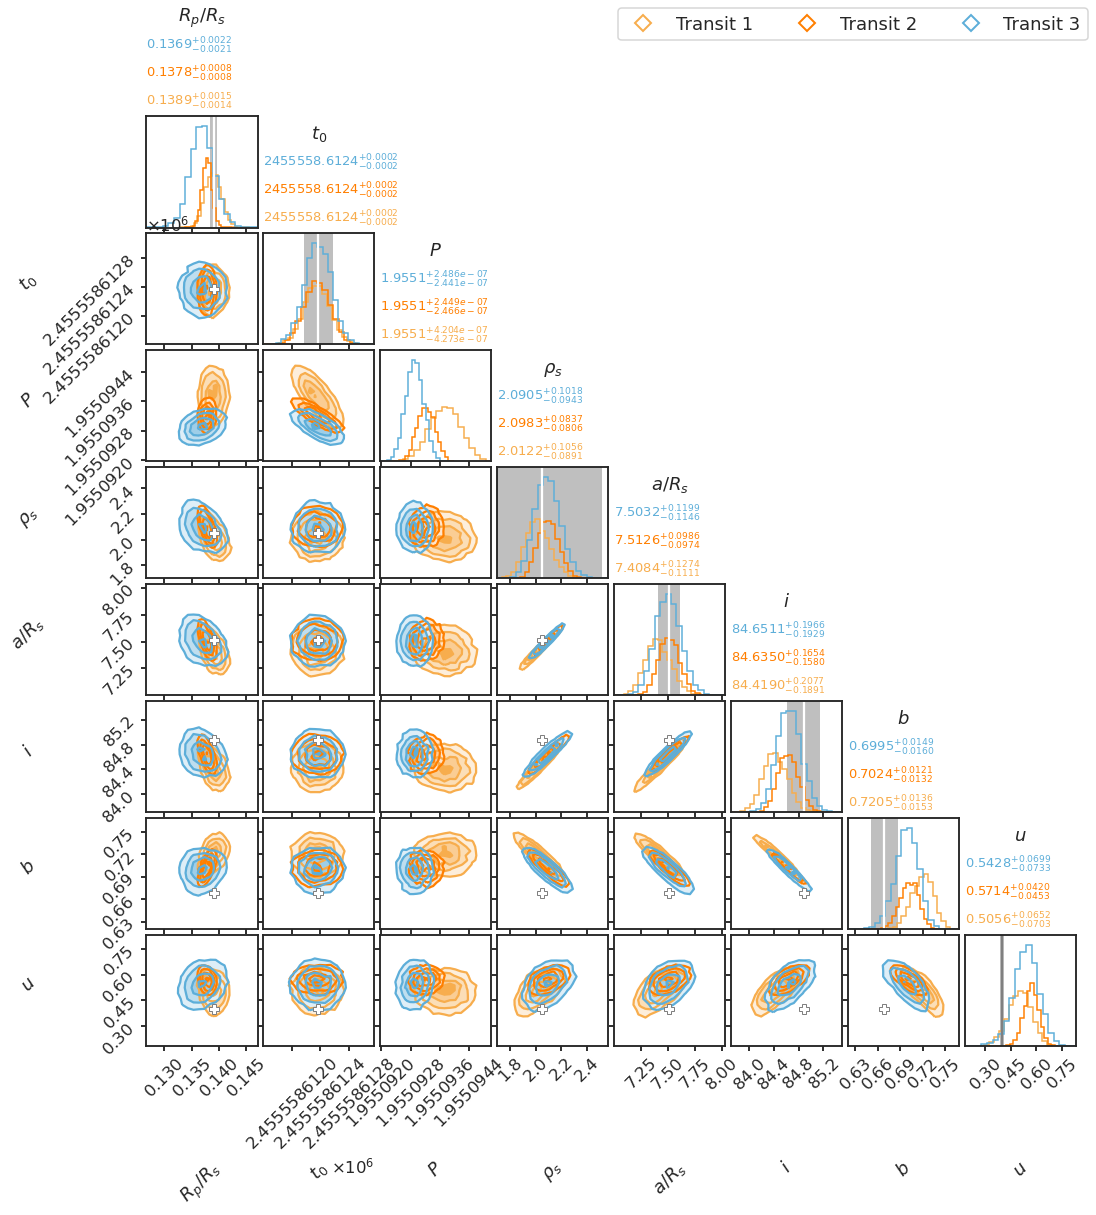

In [5]:
fig = None  # Initialize figure
for t_i, (transit_name, data) in enumerate(data_dict.items()):
    # Load
    if "rho" not in data.keys():
        G = const.G.cgs.value
        aR = data["aR"]
        P = data["P"]
        data["rho"] = 3.0 * np.pi * aR ** 3 / (G * (P * 86400.0) ** 2)
    
    # Apply t0 offset and build final data frame
    samples_all_params = {k: v for (k, v) in data.items() if "xc" not in k}#[params_dict.keys()]
    samples = {k: samples_all_params[k] for k in params_dict.keys()}
    samples["t0"] = samples_all_params["t0"] #- 2.45e6
    samples["P"] = samples_all_params["P"] #* 86_400.0
    
    #n = 3
    #ranges = [(v["truth"][0] - n*v["truth"][1], v["truth"][0] + n*v["truth"][2]) for k, v in params_dict.items()]
    
    # Plot
    fig, axes = utils.plot_corner(
        samples, fpath_truths, c=f"C{t_i}", fig=fig, #ranges=ranges,
    )

    # Custom titles
    ps = [0.16, 0.5, 0.84]
    ps_strs = [f"{p*100:.0f}%" for p in ps]
    df_stats = pd.DataFrame(samples).describe(percentiles=ps).loc[ps_strs]
    df_latex = pd.DataFrame(columns=df_stats.columns)
    df_latex.loc["p"] = df_stats.loc["50%"]
    df_latex.loc["p_u"] = df_stats.loc["84%"] - df_stats.loc["50%"]
    df_latex.loc["p_d"] = df_stats.loc["50%"] - df_stats.loc["16%"]

    titles = []
    for param, vals in df_latex.iteritems():

        if param == "P":
            fmt_vals = {"fmt_v":".4f", "fmt_vu":".4g", "fmt_vd":".4g"}
        else:
            fmt_vals = {"fmt_v":".4f", "fmt_vu":".4f", "fmt_vd":".4f"}

        titles.append(utils.write_latex_row(vals, **fmt_vals))

    ndim = len(samples)
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i, (param_key, param_data) in enumerate(params_dict.items()):
        ax = axes[i, i]  # select 1d hist
        ax.annotate(
            f"${titles[i]}$",
            xy=(0.0, 1.1 + t_i / 4.0),
            xycoords="axes fraction",
            ha="left",
            color=f"C{t_i}",
            fontsize=13,
        )

# Label custom titles
for i, (param_key, param_data) in enumerate(params_dict.items()):
    if param_key[0] == 'q':
        axv_c = "grey"
    else:
        axv_c = 'w'
    ax = axes[i, i]  # select 1d hist
    sym = param_data["symbol"]
    ax.annotate(
        sym,
        xy=(0.5, 1.1 + (t_i + 1) / 4.0),
        xycoords="axes fraction",
        ha="center",
        # color="w",
    )
    p_mean, p_u, p_d = param_data["truth"]  # Unpack mean +/-
    ax.axvspan(p_mean - p_u, p_mean + p_u, alpha=0.5, color="grey", lw=0, zorder=0)
    ax.axvline(p_mean, color=axv_c)

# Truth values
truths = [v["truth"][0] for v in params_dict.values()]
ndim = len(truths)
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.plot(truths[xi], truths[yi], "P", ms=10, mec="grey", mfc="w")

# Custom legend
handles, labels = [], []
for transit_name in list(data_dict.keys()):
    (dummy,) = plt.plot([], [], "D", ms=12, mfc="none", mew=2, label=transit_name)
    handles.append(dummy)
    labels.append(transit_name)
fig.legend(handles, labels, loc=1, fontsize=18, ncol=len(data_dict) + 1)

# Save
fig.set_size_inches(14, 14)
#utils.savefig(f"../paper/figures/detrended_wlcs_corners/corner_wlcs_l.pdf")